<a href="https://colab.research.google.com/github/titika2013/Made_HPC/blob/main/HPC_HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install SALib

In [ ]:
import time
import numpy as np
from numba import jit

from SALib.sample import saltelli
from SALib.test_functions import Ishigami

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")


In [ ]:
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-np.pi, np.pi]] * 3
}


#Зафиксируйте какую-либо многомерную скалярную функцию
и реализуйте для неё анализ чувствительности по методу Соболя
на Python с использованием библиотеки SALib.

1. Проведите анализ чувствительности,
проверьте сходимость, измерьте тайминги, 25 баллов
2. Ускорьте вычисления Python с использованием любой 
из имеющихся возможностей (PyBind11, ctypes, cython, numba), 25 баллов
3. Попробуйте добавить параллелизм в вычисления, 25 баллов
4. Оформите и представьте результаты, 25 баллов

### 1. Простая релизация

In [ ]:
A = 7.0
B = 0.1


#  Ishigami example
def eval_model(x):
    return (np.sin(x[0]) + A * np.power(np.sin(x[1]), 2) + B * np.power(x[2], 4) * np.sin(x[0]))


In [ ]:
# classic alg
time_cl_arg = []
for n in [2 ** 13, 2 ** 16, 2 ** 19]:
    param_values = saltelli.sample(problem, n, calc_second_order=True)

    Y = np.zeros(param_values.shape[0])
    start_time = time.perf_counter()
    for j in range(len(Y)):
        Y[j] = eval_model(param_values[j])
    end_time = time.perf_counter()
    exc_time = end_time - start_time
    print(f"Execution Time for n = {n} equal: {exc_time:0.3f} sec")
    time_cl_arg.append(exc_time)


Execution Time for n = 8192 equal: 1.665 sec
Execution Time for n = 65536 equal: 13.478 sec
Execution Time for n = 524288 equal: 47.657 sec


In [ ]:
%%capture
time_counter_classic = []
n_classic = []
all_start_time_classic = time.perf_counter()
for i in range(4096, 2 ** 17, 2 ** 12):
    n = i
    param_values = saltelli.sample(problem, n, calc_second_order=True)
    Y = np.zeros(param_values.shape[0])
    start_time = time.perf_counter()
    for j in range(len(Y)):
        Y[j] = eval_model(param_values[j])
    end_time = time.perf_counter()
    exc_time = end_time - start_time
    time_counter_classic.append(exc_time)
    n_classic.append(n)
all_end_time_classic = time.perf_counter()

In [ ]:
print(f"All time take = {all_end_time_classic - all_start_time_classic}")

All time take = 305.166659201


In [ ]:
print(f"Mean execution time = {np.mean(time_counter_classic):0.3f} sec")

Mean execution time = 5.645 sec


### 2. Ускоренное выполнение с использованием numba 

In [ ]:
A = 7.0
B = 0.1


#  Ishigami example
@jit(nopython=True)
def eval_model_fast(x):
    return np.sin(x[0]) + A * np.power(np.sin(x[1]), 2) + B * np.power(x[2], 4) * np.sin(x[0])

In [ ]:
# numba alg
time_cl_numba = []
for n in [2 ** 13, 2 ** 16, 2 ** 19]:
    param_values = saltelli.sample(problem, n, calc_second_order=True)

    Y = np.zeros(param_values.shape[0])
    start_time = time.perf_counter()
    for j in range(len(Y)):
        Y[j] = eval_model_fast(param_values[j])
    end_time = time.perf_counter()
    exc_time = end_time - start_time
    print(f"Execution Time for n = {n} with numba equal: {exc_time:0.3f} sec")
    time_cl_numba.append(exc_time)


Execution Time for n = 8192 with numba equal: 0.512 sec
Execution Time for n = 65536 with numba equal: 0.466 sec
Execution Time for n = 524288 with numba equal: 3.788 sec


In [ ]:
%%capture
time_counter_numba = []
n_numba = []
all_start_time_numba = time.perf_counter()
for i in range(4096, 2 ** 17, 2 ** 12):
    n = i
    param_values = saltelli.sample(problem, n, calc_second_order=True)
    Y = np.zeros(param_values.shape[0])
    start_time = time.perf_counter()
    for j in range(len(Y)):
        Y[j] = eval_model_fast(param_values[j])
    end_time = time.perf_counter()
    exc_time = end_time - start_time
    time_counter_numba.append(exc_time)
    n_numba.append(n)
all_end_time_numba = time.perf_counter()

In [ ]:
print(f"All time take with numba = {all_end_time_numba - all_start_time_numba}")

All time take with numba = 143.27094710299997


In [ ]:
print(f"Mean execution time with numba = {np.mean(time_counter_numba):0.3f} sec")

Mean execution time with numba = 0.472 sec


С помощью Numba получилось ускорить работу примерно от 3  раз

### 3. Паралельное выполнение

In [ ]:
from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor


In [ ]:
def calc_vals(n):
    param_values = saltelli.sample(problem, n, calc_second_order=True)
    Y = np.zeros(param_values.shape[0])
    start_time = time.perf_counter()
    for i in range(len(Y)):
        Y[i] = eval_model(param_values[i])
    end_time = time.perf_counter()
    exc_time = end_time - start_time
    return exc_time, n

In [ ]:
# pool = Pool(cpu_count())
all_start_time_m = time.perf_counter()
#result_cl = pool.map(calc_vals, range(4096, 2 ** 17, 2 ** 12))  # if multiprocessing  
with ThreadPoolExecutor(max_workers=4) as executor:
    result_cl = list(executor.map(calc_vals,np.arange(4096, 2**17, 2**12)))
all_end_time_m = time.perf_counter()
print(f"All time take with multiprocessing = {all_end_time_m - all_start_time_m}")

All time take with multiprocessing = 303.91801232700004


Не получилось приемлемо распараллелить вычисления

### Результаты

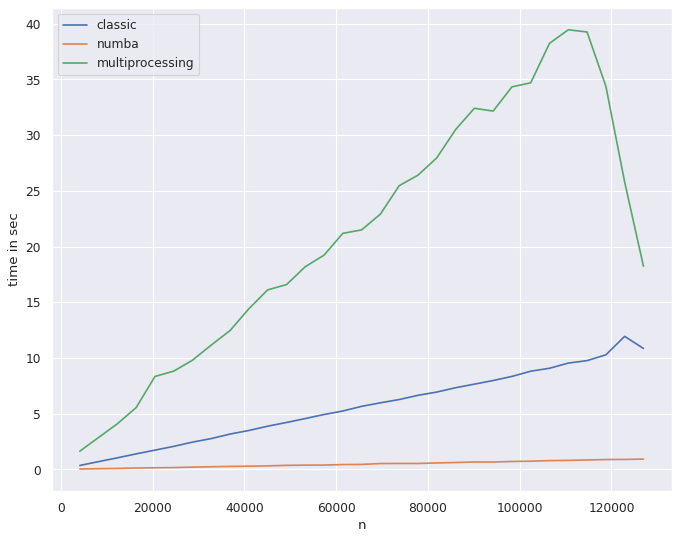

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
sns.set_theme(style="darkgrid")
sns.lineplot(x=n_classic, y=time_counter_classic, label='classic')
sns.lineplot(x=n_numba, y=time_counter_numba, label='numba')
sns.lineplot(x=[x[1] for x in result_cl], y=[x[0] for x in result_cl], label='multiprocessing')
plt.xlabel('n')
plt.ylabel('time in sec')
plt.show()

In [ ]:
print(f"Mean execution time with numba = {np.mean(time_counter_numba):0.3f} sec")
print(f"Mean execution time with multiprocessing = {((all_end_time_m - all_start_time_m)/len(result_cl)):0.3f} sec")
print(f"Mean execution time = {np.mean(time_counter_classic):0.3f} sec")

Mean execution time with numba = 0.472 sec
Mean execution time with multiprocessing = 9.804 sec
Mean execution time = 5.645 sec


Графики и время для multiprocessing не совсем корректны, но создают представление.